In [197]:
%pip install requests 
%pip install beautifulsoup4
%pip install urllib3
%pip install glob
%pip install xarray
%pip install numpy

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from requests.auth import HTTPBasicAuth
from dotenv import load_dotenv
import os
import requests
from bs4 import BeautifulSoup
import urllib.parse
import glob
import pandas as pd

In [3]:
def download_file(url, filename):
    load_dotenv()
    usr = os.getenv("USERNAME")
    pswd = os.getenv("PASSWORD")
    session = requests.Session()
    session.auth = (usr, pswd)
    response = session.get(url)
    response.raise_for_status()  
    with open(f"{filename}", "wb") as file:
        file.write(response.content)

In [ ]:
def get_first_hdf5(url: str) -> str:
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    for link in soup.find_all("a", href=True):
        if link["href"].endswith(".HDF5"):
            return urllib.parse.urljoin(url, link["href"])
    return None

In [206]:
import os
import requests
from bs4 import BeautifulSoup

def get_first_file(year, doy):
    u = (
        f"https://gpm1.gesdisc.eosdis.nasa.gov/opendap/"
        f"GPM_L2/GPM_2AKu.07/{year}/{doy:03d}/contents.html"
    )
    r = requests.get(u)
    if not r.ok:
        return None
    s = BeautifulSoup(r.text, "html.parser")
    for a in s.find_all("a"):
        h = a.get("href", "")
        if h.endswith(".HDF5.dmr.html"):
            return h.replace(".dmr.html", "")
    return None

def download_file(u, f):
    r = requests.get(u)
    r.raise_for_status()
    with open(os.path.join("data", f), "wb") as file:
        file.write(r.content)

b = "https://gpm1.gesdisc.eosdis.nasa.gov/opendap/GPM_L2/GPM_2AKu.07"
t = "?dap4.ce=/FS_Longitude[0:1:20][0:1:20];/FS_Latitude[0:1:20][0:1:20];/FS_PRE_flagPrecip[0:1:20][0:1:20];/FS_CSF_typePrecip[0:1:20][0:1:20];/FS_ScanTime_Year[0:1:20];/FS_ScanTime_DayOfYear[0:1:20];/FS_ScanTime_Month[0:1:20];/FS_ScanTime_DayOfMonth[0:1:20]"
os.makedirs("data", exist_ok=True)

for y in [2016, 2017, 2018]:
    for i in range(20):
        f = get_first_file(y, i)
        if f:
            nc4_filename = f"{f}.dap.nc4"
            file_path = os.path.join("data", nc4_filename)
            if os.path.exists(file_path):
                print(f"File {nc4_filename} already exists. Skipping download.")
                continue
            u = f"{b}/{y}/{i:03d}/{f}.dap.nc4{t}"
            print(f"Downloading {nc4_filename}...")
            download_file(u, nc4_filename)

ConnectTimeout: HTTPSConnectionPool(host='gpm1.gesdisc.eosdis.nasa.gov', port=443): Max retries exceeded with url: /opendap/GPM_L2/GPM_2AKu.07/2017/018/2A.GPM.Ku.V9-20211125.20170118-S012609-E025842.016420.V07A.HDF5.dap.nc4?dap4.ce=/FS_Longitude%5B0:1:20%5D%5B0:1:20%5D;/FS_Latitude%5B0:1:20%5D%5B0:1:20%5D;/FS_PRE_flagPrecip%5B0:1:20%5D%5B0:1:20%5D;/FS_CSF_typePrecip%5B0:1:20%5D%5B0:1:20%5D;/FS_ScanTime_Year%5B0:1:20%5D;/FS_ScanTime_DayOfYear%5B0:1:20%5D;/FS_ScanTime_Month%5B0:1:20%5D;/FS_ScanTime_DayOfMonth%5B0:1:20%5D (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000002AC1686A420>, 'Connection to gpm1.gesdisc.eosdis.nasa.gov timed out. (connect timeout=None)'))

In [ ]:
os.makedirs("data_combined", exist_ok=True)
def combine_files(save=False):
    file_path = "data/*.csv"

    # Use glob to get all files with the .csv extension
    csv_files = glob.glob(file_path)

    # Combine all CSV files into one DataFrame
    combined = []
    for file in csv_files:
        combined.append(pd.read_csv(file))

    # we concatenate all the dataframes into one because they were kind-of like [ [2000], [2001]. [2002], [2003], [2004] ] and we want to make it [combined]
    combined = pd.concat(combined, ignore_index=True)
    if save:
        combined.to_csv("data_combined/combined_data.csv", index=False)
    return combined

In [181]:
df = pd.read_csv("data/2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.csv")
df = df.transpose()
df2 = pd.read_hdf("data/2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.csv")
df2
os.makedirs("data_comb", exist_ok=True)
df.to_csv("data_comb/transposed_2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.csv")
df = pd.read_csv("data_comb/transposed_2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.csv")

df


HDF5ExtError: HDF5 error back trace

  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5F.c", line 620, in H5Fopen
    unable to open file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5PLpath.c", line 712, in H5PL__path_table_iterate_process_path
    can't open directory
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5Fint.c", line 1990, in H5F_open
    unable to read superblock
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5Fsuper.c", line 405, in H5F__super_read
    file signature not found

End of HDF5 error back trace

Unable to open/create file 'data/2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.csv'

In [169]:

def combine_files(save=False):
    file_path = "data/*.csv"

    # Use glob to get all files with the .csv extension
    csv_files = glob.glob(file_path)

    # Combine all CSV files into one DataFrame
    combined = []
    for file in csv_files:
        combined.append(pd.read_csv(file))

    # we concatenate all the dataframes into one because they were kind-of like [ [2000], [2001]. [2002], [2003], [2004] ] and we want to make it [combined]
    combined = pd.concat(combined, ignore_index=True)
    os.makedirs("data_comb", exist_ok=True)
    if save:
        combined.to_csv("data_comb/combined_data.csv", index=False)
    return combined

In [179]:
cc = combine_files(True)
cc.dropna()
cc = cc.transpose()
cc.to_clipboard()
cc

,0,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,172,173
/FS_Longitude[0],/FS_Longitude[1],/FS_Longitude[2],/FS_Longitude[3],/FS_Longitude[4],/FS_Longitude[5],/FS_Longitude[6],/FS_Longitude[7],/FS_Longitude[8],/FS_Longitude[9],/FS_Longitude[10],...,/FS_CSF_typePrecip[15],/FS_CSF_typePrecip[16],/FS_CSF_typePrecip[17],/FS_CSF_typePrecip[18],/FS_CSF_typePrecip[19],/FS_CSF_typePrecip[20],/FS_ScanTime_Year,/FS_ScanTime_DayOfYear,/FS_ScanTime_Month,/FS_ScanTime_DayOfMonth
98.0694,98.1788,98.288,98.3973,98.5064,98.6156,98.7249,98.8341,98.9433,99.0526,99.1619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98.0689,98.178,98.2869,98.396,98.505,98.6139,98.7229,98.8319,98.9409,99.0501,99.1591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98.0684,98.1773,98.286,98.3949,98.5036,98.6123,98.7211,98.8299,98.9387,99.0476,99.1564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98.068,98.1767,98.2852,98.3939,98.5024,98.6108,98.7195,98.828,98.9366,99.0453,99.1538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83.3968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1111.0,-1111.0,-1111.0,-1111.0,-1111.0,-1111.0,NaN,NaN,NaN,NaN
83.4003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1111.0,-1111.0,-1111.0,-1111.0,-1111.0,-1111.0,NaN,NaN,NaN,NaN
83.4039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1111.0,-1111.0,-1111.0,-1111.0,-1111.0,-1111.0,NaN,NaN,NaN,NaN
83.4076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1111.0,-1111.0,-1111.0,-1111.0,-1111.0,-1111.0,NaN,NaN,NaN,NaN


In [ ]:
combined = combine_files(True)

In [ ]:
combined

,Dataset: 2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160102-S010112-E023343.010477.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160103-S000914-E014145.010492.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160104-S004947-E022218.010508.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160105-S013019-E030249.010524.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160106-S003817-E021048.010539.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160107-S011846-E025117.010555.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160108-S002643-E015913.010570.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160109-S010709-E023940.010586.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20160110-S001503-E014734.010601.V07A.HDF5,...,Dataset: 2A.GPM.Ku.V9-20211125.20180110-S011224-E024458.021973.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180111-S002115-E015349.021988.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180112-S010241-E023515.022004.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180113-S001132-E014406.022019.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180114-S005257-E022532.022035.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180115-S000147-E013421.022050.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180116-S004312-E021546.022066.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180117-S012436-E025711.022082.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180118-S003325-E020559.022097.V07A.HDF5,Dataset: 2A.GPM.Ku.V9-20211125.20180119-S011449-E024723.022113.V07A.HDF5
0,98.1482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,98.2481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,98.3481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,98.4483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98.5483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1111.0
5012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
combined.columns[1]

'Dataset: 2A.GPM.Ku.V9-20211125.20160102-S010112-E023343.010477.V07A.HDF5'

In [ ]:
columns

combined.pivot()

In [ ]:
transform_csv("data_combined/combined_data.csv", "data_combined/transformed_combined_data.csv")

Transformed CSV saved to: data_combined/transformed_combined_data.csv


In [184]:
%pip install netCDF4

   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB 2.0 MB/s eta 0:00:04
    --------------------------------------- 0.2/7.0 MB 2.1 MB/s eta 0:00:04
   -- ------------------------------------- 0.4/7.0 MB 3.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.7/7.0 MB 4.0 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.0 MB 4.6 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.0 MB 4.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.0 MB 4.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.0 MB 4.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.0 MB 4.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.0 MB 4.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.0 MB 4.4 MB/s eta 0:00:02
   ----- -----------------

In [189]:
import netCDF4
from netCDF4 import Dataset

In [198]:
import numpy as np

In [201]:
nc = Dataset("2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.nc4", mode='r')
print(nc.variables)

# --- Read data arrays ---
lon = nc.variables["FS_Longitude"][:]       # (21, 21)
lat = nc.variables["FS_Latitude"][:]        # (21, 21)
flag_precip = nc.variables["FS_PRE_flagPrecip"][:]  # (21, 21)
type_precip = nc.variables["FS_CSF_typePrecip"][:]  # (21, 21)

year = nc.variables["FS_ScanTime_Year"][:]         # (21,)
doy = nc.variables["FS_ScanTime_DayOfYear"][:]     # (21,)
month = nc.variables["FS_ScanTime_Month"][:]       # (21,)
day = nc.variables["FS_ScanTime_DayOfMonth"][:]    # (21,)

# --- Helper: broadcast any 1D time array to full 2D grid ---
def broadcast_to_grid(arr_1d, target_shape):
    if arr_1d.ndim == 1:
        # Repeat each scan-time value across all rays in that scan
        return np.repeat(arr_1d[:, np.newaxis], target_shape[1], axis=1)
    return arr_1d

year_2d = broadcast_to_grid(year, lon.shape)
doy_2d = broadcast_to_grid(doy, lon.shape)
month_2d = broadcast_to_grid(month, lon.shape)
day_2d = broadcast_to_grid(day, lon.shape)

# --- Flatten everything to 1D ---
def flat(a):
    return a.ravel()

df = pd.DataFrame({
    "Longitude": flat(lon),
    "Latitude": flat(lat),
    "FlagPrecip": flat(flag_precip),
    "TypePrecip": flat(type_precip),
    "Year": flat(year_2d),
    "Month": flat(month_2d),
    "DayOfMonth": flat(day_2d),
    "DayOfYear": flat(doy_2d),
})

print(df.head())
print(f"DataFrame shape: {df.shape}")

# --- Optional: save to CSV ---
df.to_csv("gpm_fs_full.csv", index=False)

{'FS_Longitude': <class 'netCDF4.Variable'>
float32 FS_Longitude(nscan, nray)
    DimensionNames: nscan,nray
    CodeMissingValue: -9999.9
    origname: Longitude
    fullnamepath: /FS/Longitude
    units: degrees_east
    _FillValue: -9999.9
unlimited dimensions: 
current shape = (21, 21)
filling off, 'FS_Latitude': <class 'netCDF4.Variable'>
float32 FS_Latitude(nscan, nray)
    DimensionNames: nscan,nray
    CodeMissingValue: -9999.9
    origname: Latitude
    fullnamepath: /FS/Latitude
    units: degrees_north
    _FillValue: -9999.9
unlimited dimensions: 
current shape = (21, 21)
filling off, 'FS_PRE_flagPrecip': <class 'netCDF4.Variable'>
int32 FS_PRE_flagPrecip(nscan, nray)
    DimensionNames: nscan,nray
    _FillValue: -9999
    CodeMissingValue: -9999
    origname: flagPrecip
    fullnamepath: /FS/PRE/flagPrecip
    coordinates: FS_Longitude FS_Latitude
unlimited dimensions: 
current shape = (21, 21)
filling off, 'FS_CSF_typePrecip': <class 'netCDF4.Variable'>
int32 FS_CSF_type

In [207]:
def filenames():
    file_path = "data/*.nc4"
    nc4_files = glob.glob(file_path)
    return nc4_files

In [209]:
fnames = filenames()
print(fnames)

['data\\2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160102-S010112-E023343.010477.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160103-S000914-E014145.010492.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160104-S004947-E022218.010508.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160105-S013019-E030249.010524.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160106-S003817-E021048.010539.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160107-S011846-E025117.010555.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160108-S002643-E015913.010570.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160109-S010709-E023940.010586.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160110-S001503-E014734.010601.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160111-S005528-E022758.010617.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-20211125.20160112-S000319-E013550.010632.V07A.HDF5.dap.nc4', 'data\\2A.GPM.Ku.V9-2021112

In [217]:
import os
import numpy as np
import pandas as pd
from netCDF4 import Dataset

# --- Create output directory ---
os.makedirs("nc4tocsv", exist_ok=True)


# --- Helper: broadcast a 1D array to match a 2D grid shape ---
def broadcast_to_grid(arr_1d, target_shape):
    if arr_1d.ndim == 1:
        # Repeat each scan-time value across all rays in that scan
        return np.repeat(arr_1d[:, np.newaxis], target_shape[1], axis=1)
    return arr_1d


def flat(a):
    return a.ravel()


# --- List of NetCDF4 files (make sure fnames is defined) ---
# Example:
# fnames = ["path/to/file1.nc4", "path/to/file2.nc4", ...]

for f, ncfile in enumerate(fnames):
    print(f"\nProcessing file {f+1}/{len(fnames)}: {ncfile}")

    # Safely open NetCDF file
    with Dataset(ncfile, mode="r") as nc:
        # --- Read data arrays ---
        lon = nc.variables["FS_Longitude"][:]        # (21, 21)
        lat = nc.variables["FS_Latitude"][:]         # (21, 21)
        flag_precip = nc.variables["FS_PRE_flagPrecip"][:]  # (21, 21)
        type_precip = nc.variables["FS_CSF_typePrecip"][:]  # (21, 21)

        year = nc.variables["FS_ScanTime_Year"][:]         # (21,)
        doy = nc.variables["FS_ScanTime_DayOfYear"][:]     # (21,)
        month = nc.variables["FS_ScanTime_Month"][:]       # (21,)
        day = nc.variables["FS_ScanTime_DayOfMonth"][:]    # (21,)

        # --- Broadcast time arrays to match lon/lat grid ---
        year_2d = broadcast_to_grid(year, lon.shape)
        doy_2d = broadcast_to_grid(doy, lon.shape)
        month_2d = broadcast_to_grid(month, lon.shape)
        day_2d = broadcast_to_grid(day, lon.shape)

        # --- Flatten to 1D ---
        df = pd.DataFrame({
            "Longitude": flat(lon),
            "Latitude": flat(lat),
            "FlagPrecip": flat(flag_precip),
            "TypePrecip": flat(type_precip),
            "Year": flat(year_2d),
            "Month": flat(month_2d),
            "DayOfMonth": flat(day_2d),
            "DayOfYear": flat(doy_2d),
        })

    print(df.head())
    print(f"DataFrame shape: {df.shape}")

    # --- Save to CSV using iteration index or file basename ---
    base = os.path.splitext(os.path.basename(ncfile))[0]
    csv_path = f"nc4tocsv/{base}.csv"
    df.to_csv(csv_path, index=False)

    print(f"✅ Saved CSV: {csv_path}")

print("\nAll NetCDF files successfully processed and converted to CSV.")


Processing file 1/36: data\2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.dap.nc4
   Longitude   Latitude  FlagPrecip  TypePrecip  Year  Month  DayOfMonth  \
0  98.069443 -66.285118           0       -1111  2016      1           1   
1  98.068863 -66.234558           0       -1111  2016      1           1   
2  98.068390 -66.184044           0       -1111  2016      1           1   
3  98.068039 -66.134201           0       -1111  2016      1           1   
4  98.067802 -66.084824           0       -1111  2016      1           1   

   DayOfYear  
0          1  
1          1  
2          1  
3          1  
4          1  
DataFrame shape: (441, 8)
✅ Saved CSV: nc4tocsv/2A.GPM.Ku.V9-20211125.20160101-S002036-E015307.010461.V07A.HDF5.dap.csv

Processing file 2/36: data\2A.GPM.Ku.V9-20211125.20160102-S010112-E023343.010477.V07A.HDF5.dap.nc4
   Longitude   Latitude  FlagPrecip  TypePrecip  Year  Month  DayOfMonth  \
0  83.326080 -66.284569           0       -1111  2016    

In [218]:

def combine_files(save=False):
    file_path = "nc4tocsv/*.csv"

    # Use glob to get all files with the .csv extension
    csv_files = glob.glob(file_path)

    # Combine all CSV files into one DataFrame
    combined = []
    for file in csv_files:
        combined.append(pd.read_csv(file))

    # we concatenate all the dataframes into one because they were kind-of like [ [2000], [2001]. [2002], [2003], [2004] ] and we want to make it [combined]
    combined = pd.concat(combined, ignore_index=True)
    os.makedirs("data_comb", exist_ok=True)
    if save:
        combined.to_csv("data_comb/combined_data.csv", index=False)
    return combined

cc = combine_files()
cc

,Longitude,Latitude,FlagPrecip,TypePrecip,Year,Month,DayOfMonth,DayOfYear
0,98.06944,-66.285120,0,-1111,2016,1,1,1
1,98.06886,-66.234560,0,-1111,2016,1,1,1
2,98.06839,-66.184044,0,-1111,2016,1,1,1
3,98.06804,-66.134200,0,-1111,2016,1,1,1
4,98.06780,-66.084820,0,-1111,2016,1,1,1
...,...,...,...,...,...,...,...,...
15871,-142.03660,-64.743170,0,-1111,2017,1,17,17
15872,-142.03029,-64.789696,0,-1111,2017,1,17,17
15873,-142.02405,-64.836120,0,-1111,2017,1,17,17
15874,-142.01788,-64.882510,0,-1111,2017,1,17,17


In [224]:
%pip install scikit-learn
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 653.6 kB/s eta 0:01:27
   ---------------------------------------- 0.1/56.8 MB 980.4 kB/s eta 0:00:58
   ---------------------------------------- 0.2/56.8 MB 1.2 MB/s eta 0:00:46
   ---------------------------------------- 0.3/56.8 MB 1.7 MB/s eta 0:00:33
   ---------------------------------------- 0.5/56.8 MB 2.2 MB/s eta 0:00:26
    --------------------------------------- 0.8/56.8 MB 2.7 MB/s eta 0:00:21
    --------------------------------------- 1.0/56.8 MB 2.9 MB/s eta 0:00:20
    --------------------------------------- 1.2/56.8 MB 3.1 MB/s eta 0:00:19
   - -------------------------------------- 1.4/56.8 MB 3.4 MB/s eta 0:00:17
   - -------------------------------------- 1.7/56.8 MB 3.6 MB/s eta 0:00:16
   - ---------------

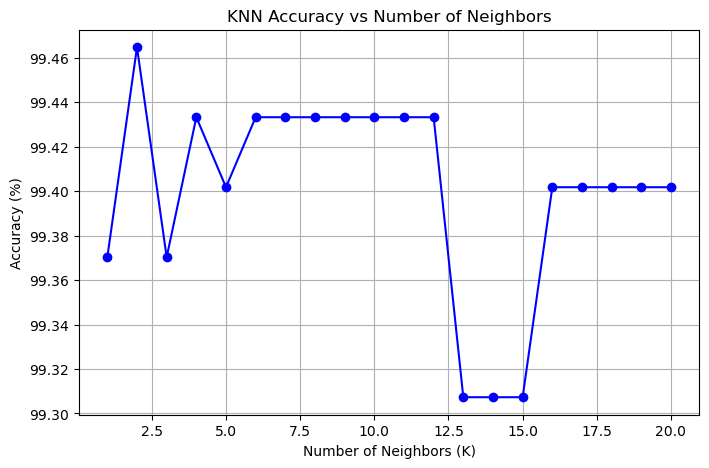

📈 Best K = 2 with accuracy = 99.46%


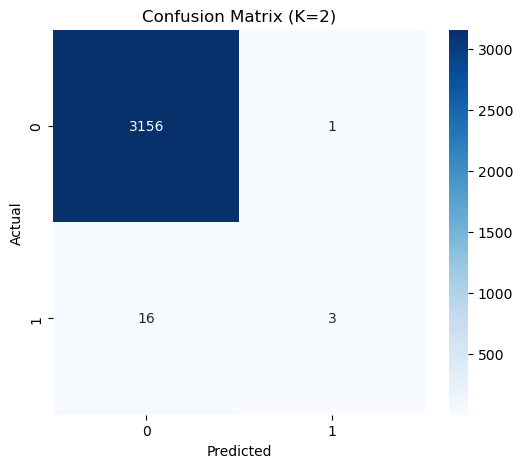

📊 Classification Report:

              precision    recall  f1-score      support
0              0.994956  0.999683  0.997314  3157.000000
1              0.750000  0.157895  0.260870    19.000000
accuracy       0.994647  0.994647  0.994647     0.994647
macro avg      0.872478  0.578789  0.629092  3176.000000
weighted avg   0.993490  0.994647  0.992908  3176.000000


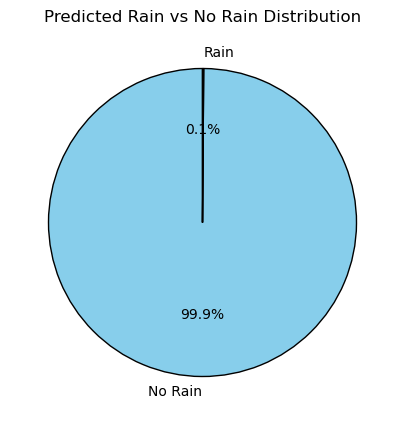

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# --- Load your data ---
data = cc.copy()

# --- Data cleaning ---
data = data.dropna(subset=["FlagPrecip"])
data = data[data["FlagPrecip"] != -1111]

# Define features and target
X = data[["Longitude", "Latitude", "Year", "Month", "DayOfMonth", "DayOfYear"]]
y = data["FlagPrecip"]

# Binary rain/no-rain
y = np.where(y > 0, 1, 0)

# --- Split into training/testing ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Find best K ---
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred))

# --- Plot K vs accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, [a * 100 for a in accuracies], marker='o', color='b')
plt.title("KNN Accuracy vs Number of Neighbors")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

# --- Train final model on best K ---
best_k = k_values[np.argmax(accuracies)]
print(f"📈 Best K = {best_k} with accuracy = {max(accuracies) * 100:.2f}%")

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)
y_pred = knn_final.predict(X_test_scaled)

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (K={best_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Classification Report ---
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("📊 Classification Report:\n")
print(report_df)

# --- Pie chart of predictions ---
plt.figure(figsize=(5, 5))
labels = ["No Rain", "Rain"]
sizes = [np.sum(y_pred == 0), np.sum(y_pred == 1)]
colors = ["skyblue", "lightcoral"]
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "black"},
)
plt.title("Predicted Rain vs No Rain Distribution")
plt.show()

📊 Balanced set: 0s=11047, 1s=11047

🔧 Best threshold = 0.987 | F1 = 0.651

🔹 Default Threshold (0.5) Results

🧩 Classification Report (Default Threshold (0.5)):
              precision    recall  f1-score      support
0              0.998270  0.974863  0.986427  4734.000000
1              0.150000  0.724138  0.248521    29.000000
accuracy       0.973336  0.973336  0.973336     0.973336
macro avg      0.574135  0.849500  0.617474  4763.000000
weighted avg   0.993105  0.973336  0.981934  4763.000000


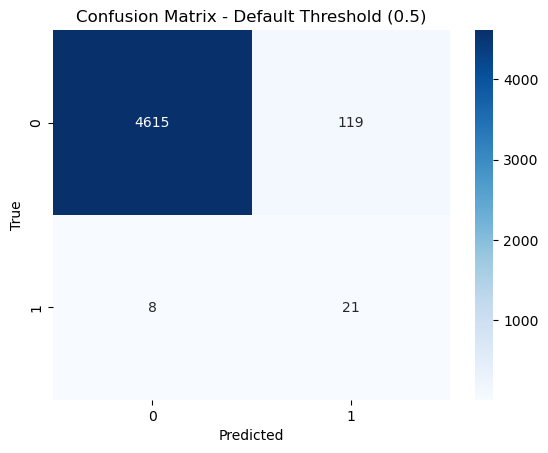


🔹 Optimized Threshold Results

🧩 Classification Report (Optimized Threshold (0.99)):
              precision    recall  f1-score      support
0              0.996841  1.000000  0.998418  4734.000000
1              1.000000  0.482759  0.651163    29.000000
accuracy       0.996851  0.996851  0.996851     0.996851
macro avg      0.998421  0.741379  0.824791  4763.000000
weighted avg   0.996861  0.996851  0.996304  4763.000000


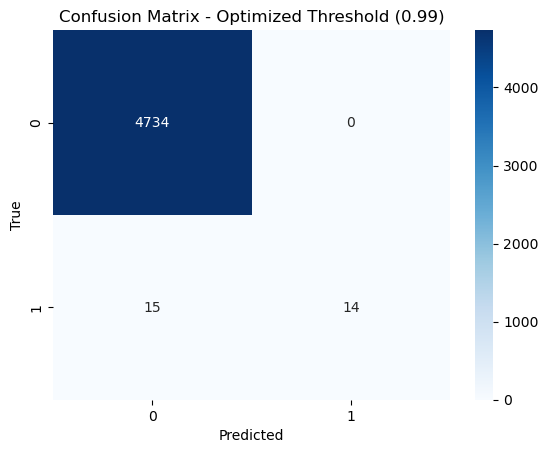

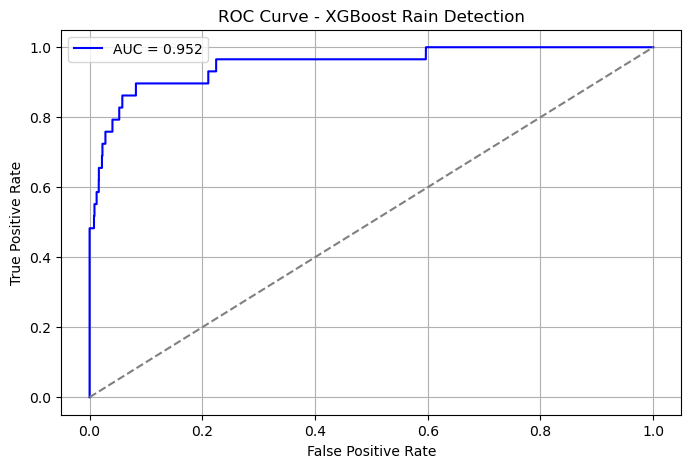

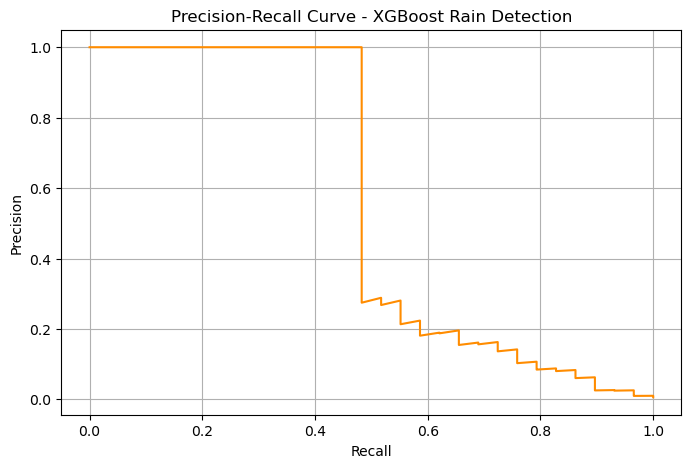

In [230]:
# ============================================================
# 🌧️ Improved Rain Prediction Model: XGBoost + SMOTE + Threshold tuning
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# ------------------------------------------
# 1️⃣ LOAD & CLEAN DATA
# ------------------------------------------
data = cc.copy()
data = data.dropna(subset=["FlagPrecip"])
data = data[data["FlagPrecip"] != -1111]

X = data[["Longitude", "Latitude", "Year", "Month", "DayOfMonth", "DayOfYear"]]
y = np.where(data["FlagPrecip"] > 0, 1, 0)

# ------------------------------------------
# 2️⃣ TRAIN TEST SPLIT
# ------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3,  stratify=y
)

# ------------------------------------------
# 3️⃣ SCALE + BALANCE (SMOTE)
# ------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)
print(f"📊 Balanced set: 0s={sum(y_res==0)}, 1s={sum(y_res==1)}")

# ------------------------------------------
# 4️⃣ TRAIN XGBOOST (with imbalance handling)
# ------------------------------------------
scale_pos_weight = (len(y_res) - sum(y_res)) / sum(y_res)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    n_jobs=-1,
)
xgb.fit(X_res, y_res)

# ------------------------------------------
# 5️⃣ PREDICT & OPTIMIZE THRESHOLD
# ------------------------------------------
y_proba = xgb.predict_proba(X_test_scaled)[:, 1]  # probabilities for "Rain"

# Default threshold (0.5)
y_pred_default = (y_proba >= 0.5).astype(int)

# Try a range of thresholds to find the best tradeoff
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1s = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]

print(f"\n🔧 Best threshold = {best_thresh:.3f} | F1 = {f1s[best_idx]:.3f}")

# Apply best threshold
y_pred_opt = (y_proba >= best_thresh).astype(int)

# ------------------------------------------
# 6️⃣ EVALUATE (before/after threshold tuning)
# ------------------------------------------
def evaluate_model(y_true, y_pred, label):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n🧩 Classification Report ({label}):")
    print(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose())
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("\n🔹 Default Threshold (0.5) Results")
evaluate_model(y_test, y_pred_default, "Default Threshold (0.5)")

print("\n🔹 Optimized Threshold Results")
evaluate_model(y_test, y_pred_opt, f"Optimized Threshold ({best_thresh:.2f})")

# ------------------------------------------
# 7️⃣ ROC + Precision-Recall Plot
# ------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - XGBoost Rain Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, color="darkorange")
plt.title("Precision-Recall Curve - XGBoost Rain Detection")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()